<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Построим модель с предельно большим значением *F1*-меры. Чтобы считать проект успешным, доведем метрику до 0.59.

Дополнительно измерим *AUC-ROC*, сравнивая её значение с *F1*-мерой.

**Цели исследования:**
Построение модели для прогнозирования, уйдет ли клиент из банка в ближайшее время.

**Описание данных:** Датасет с информацией о поведении клиентов и расторжении договоров с банком.

## Подготовка данных

**1.1 Импортируем необходимые библиотеки, считаем данные из csv-файла в датафрейм, сохраним в переменную data и выведем ее на экран**

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**1.2 Выведем основную информацию о датафрейме**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**1.3 Приведем названия столбцов к нижнему регистру**

In [4]:
data.columns = data.columns.str.lower()

In [5]:
# Выведем обновленный датафрейм на экран:

data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**1.4 Заполним пропуски в данных**

In [6]:
# Выведем перечень уникальных значений столбца tenure:

data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [7]:
# Заменим пропуски медианным значением:

data['tenure'] = data['tenure'].fillna(data['tenure'].median())

**1.5 Изменим тип данных**

In [8]:
# В столбце tenure на int:

data['tenure'] = data['tenure'].astype(int)

**1.6 Избавимся от аномальных и выбивающихся значений**

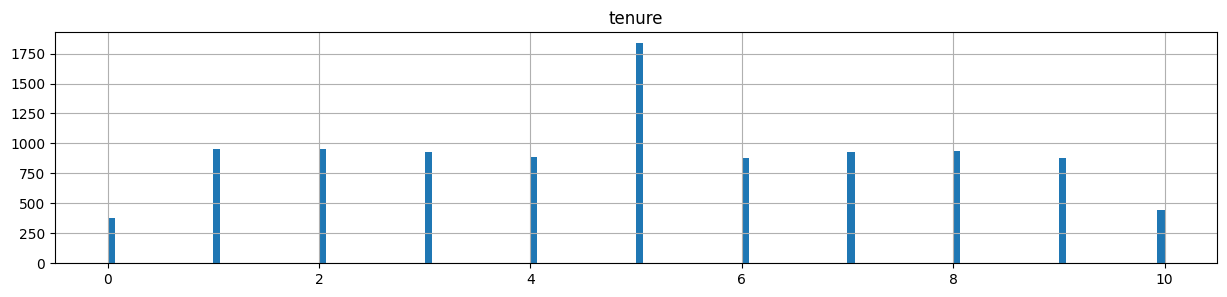

In [9]:
# При помощи гистограмм и команды unique изучим данные в столбцах
# более подробно:

data.hist(column='tenure', bins=150, figsize=(15,3));

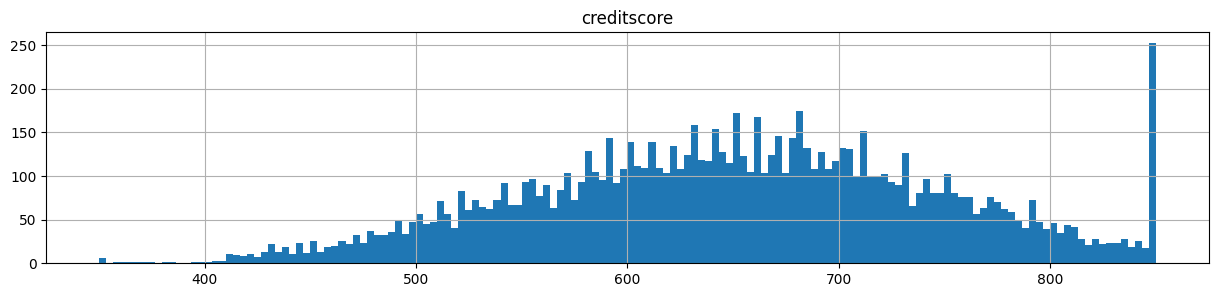

In [10]:
data.hist(column='creditscore', bins=150, figsize=(15,3));

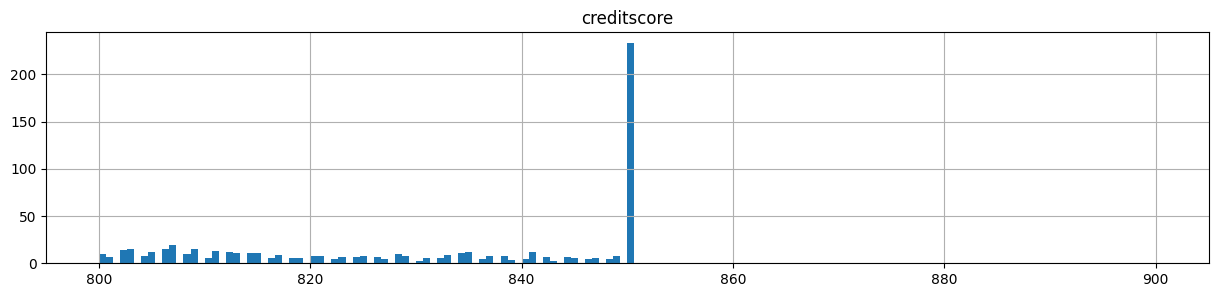

In [11]:
data.hist(column='creditscore', bins=150, figsize=(15,3), range=(800,900));

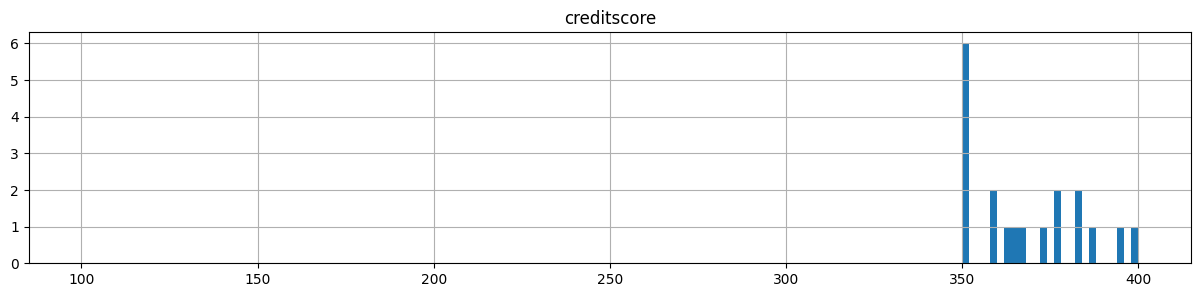

In [12]:
data.hist(column='creditscore', bins=150, figsize=(15,3), range=(100,400));

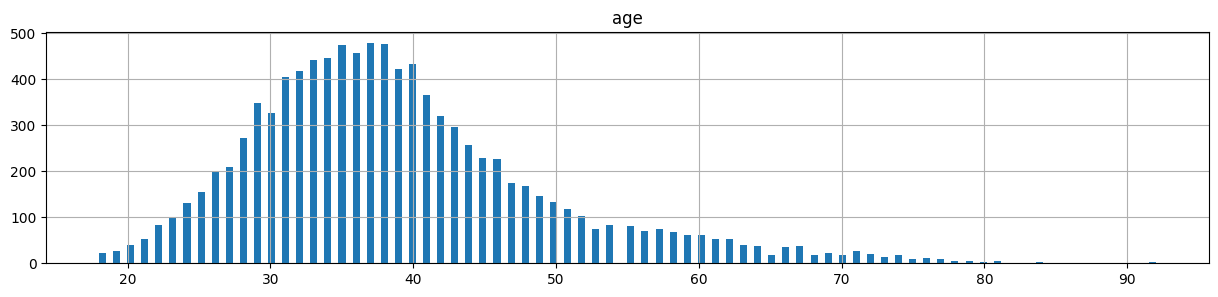

In [13]:
data.hist(column='age', bins=150, figsize=(15,3));

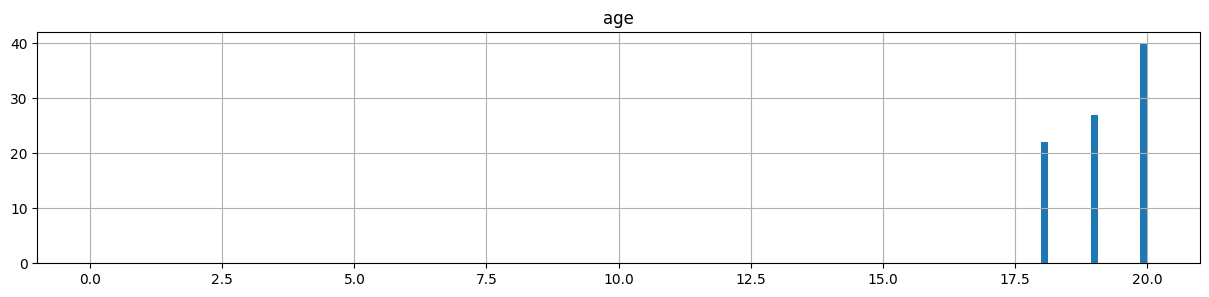

In [14]:
data.hist(column='age', bins=150, figsize=(15,3), range=(0,20));

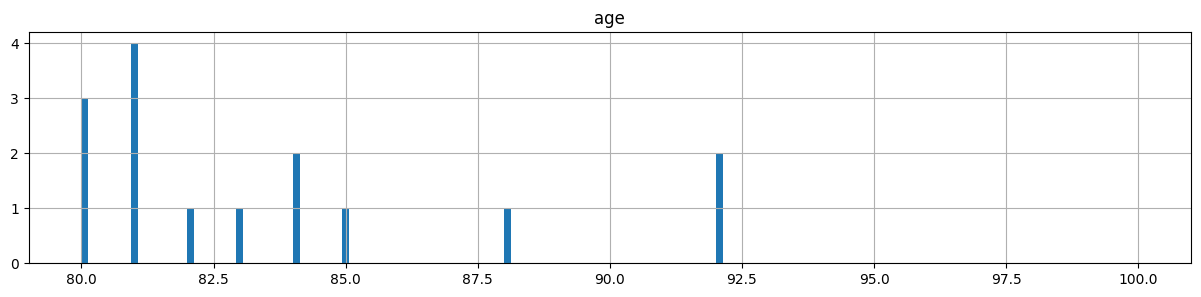

In [15]:
data.hist(column='age', bins=150, figsize=(15,3), range=(80,100));

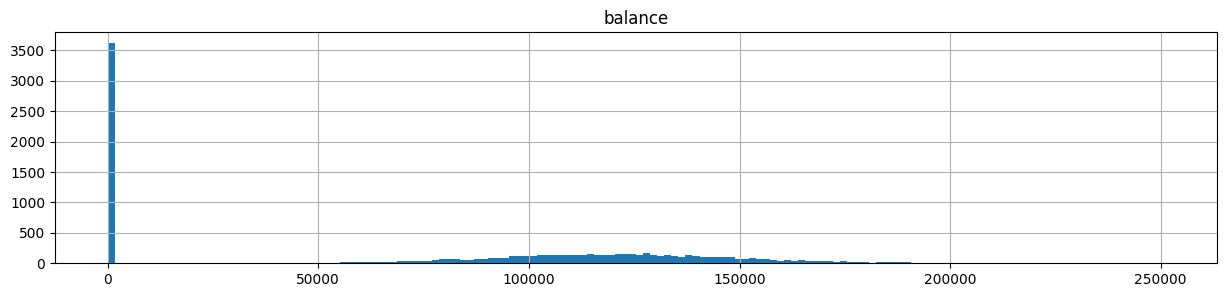

In [16]:
data.hist(column='balance', bins=150, figsize=(15,3));

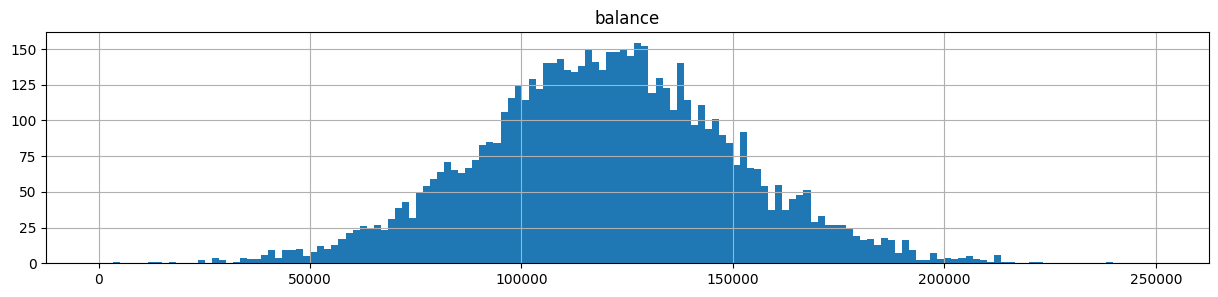

In [17]:
data.hist(column='balance', bins=150, figsize=(15,3), range=(100,250000));

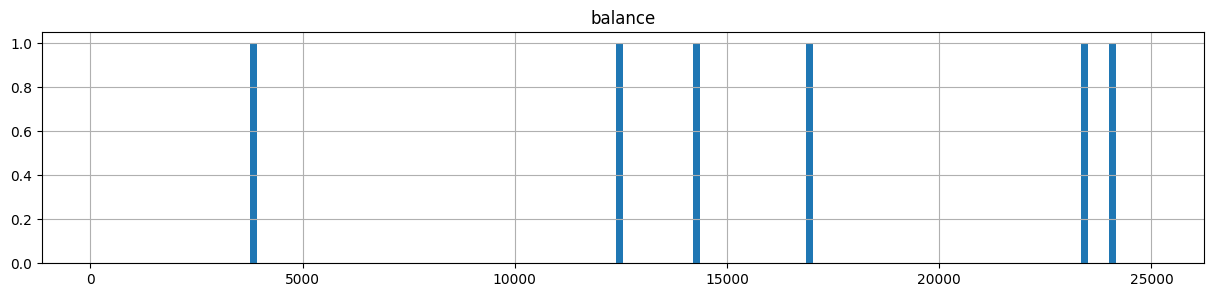

In [18]:
data.hist(column='balance', bins=150, figsize=(15,3), range=(100,25000));

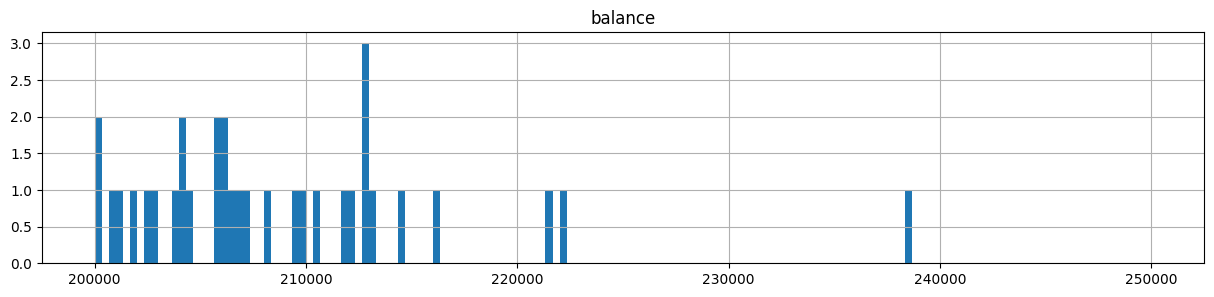

In [19]:
data.hist(column='balance', bins=150, figsize=(15,3), range=(200000,250000));

In [20]:
data['numofproducts'].unique()

array([1, 3, 2, 4])

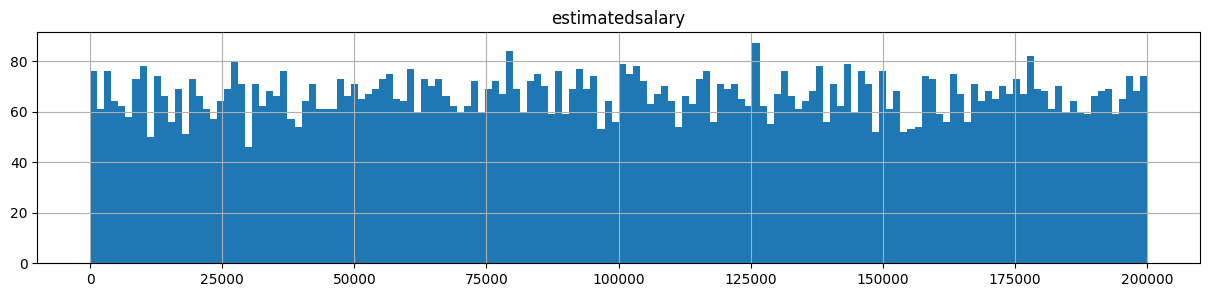

In [21]:
data.hist(column='estimatedsalary', bins=150, figsize=(15,3));

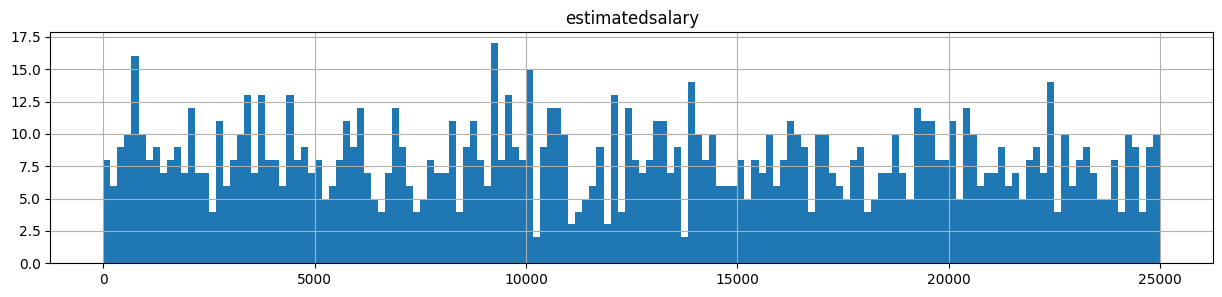

In [22]:
data.hist(column='estimatedsalary', bins=150, figsize=(15,3), range=(0,25000));

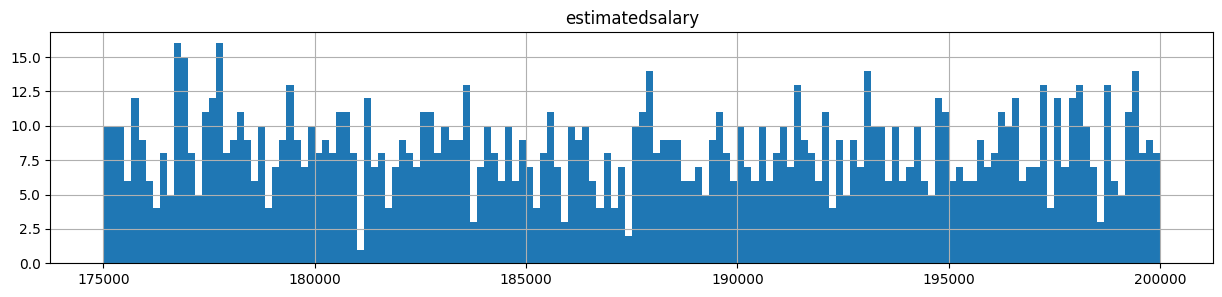

In [23]:
data.hist(column='estimatedsalary', bins=150, figsize=(15,3), range=(175000,200000));

**1.7 Проверим датасет на наличие дубликатов**

In [24]:
data.duplicated().sum()

0

In [25]:
# Выведем обновленную информацию о датасете:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [26]:
# Удалим столбцы rownumber, customerid и surname из датасета:

data = data.drop(['rownumber', 'customerid', 'surname'], axis=1)

In [27]:
# Выведем обновленный датасет на экран:

data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Вывод:** Названия столбцов приведены к нижнему регистру для удобства работы.

Пропуски в столбце Tenure заменены медианным значением. Тип данных изменен на int для большей ясности.

Удалены три столбца с неколичественными данными: rownumber, customerid, surname.



## Исследование задачи

**2.1 Подготовка выборок**

In [28]:
# Закодируем цифрами выраженные в тексте категории:
data_ohe = pd.get_dummies(data, drop_first=True)

# Выведем обновленный датасет на экран:
data_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [29]:
# Выделим из датасета признаки и целевой признак:

target = data_ohe['exited']
features = data_ohe.drop(['exited'], axis=1)

In [30]:
# Выделим из признаков и целевого признака тестовые:

features_1, features_test, target_1, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [31]:
# Разделим оставшиеся признаки и целевой признак на обучающие и валидационные:

features_train, features_valid, target_train, target_valid = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)

In [32]:
# Выделим численные столбцы:

numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']

In [33]:
# Произведем масштабирование признаков:

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [34]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**2.2 Обучение моделей**

In [35]:
# Обучим модель LogisticRegression на тренировочной выборке:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)

# Применим ее к валидационной выборке:
predictions_valid = model.predict(features_valid)

# Выведем на экран оценку F1-меры:
print ("F1:", f1_score(target_valid, predictions_valid))

F1: 0.3131115459882583


In [36]:
# Определим площадь ROC-кривой для этой модели:

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.790031684562577


In [37]:
# Создадим цикл и определим глубину дерева для DecisionTreeClassifier при
# наибольшем значении F1-меры:

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 90):
  model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
  model.fit(features_train, target_train)
  predictions_valid = model.predict(features_valid)
  result = f1_score(target_valid, predictions_valid)

  if result > best_result:
    best_model = model
    best_result = result
    best_depth = depth

print("F1 лучшей модели:", best_result, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.5794392523364486 Глубина дерева: 9


In [38]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8055395176905473


In [39]:
# Создадим вложенный цикл и определим количество оценщиков и глубину дерева для
# RandomForestClassifier при наибольшем значении F1-меры:

best_model = None
best_result = 0
best_estimators = 0
best_depth = 0

for est in range(1, 90):
  for depth in range(1, 90):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)

    if result > best_result:
      best_model = model
      best_result = result
      best_estimators = est
      best_depth = depth

print("F1 лучшей модели:", best_result, "Количество оценщиков:", best_estimators, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.6019417475728156 Количество оценщиков: 78 Глубина дерева: 15


In [40]:
model = RandomForestClassifier(random_state=12345, n_estimators=78, max_depth=15)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8637343777503961


**2.3 Исследуем баланс классов**

In [41]:
# Составим матрицу ошибок для наилучшего результата:

predictions_valid = model.predict(features_valid)
confusion_matrix(target_valid, predictions_valid)

array([[1443,   52],
       [ 194,  186]])

In [42]:
# Определим для него полноту:

recall_score(target_valid, predictions_valid)

0.48947368421052634

In [43]:
# И точность:

precision_score(target_valid, predictions_valid)

0.7815126050420168

**Вывод:** Выраженные в тексте категории закодированы цифрами. Произведено разделение данных не тестовую, валидационную и обучающую выборки и последующее масштабирование признаков.

К тренировочной выборке применены алгоритмы классификации (Решающее дерево, Случайный лес, Логистическая регрессия) с перебором гиперпараметров. В результате проверки обученных моделей на валидационной выборке, наилучшим образом себя показал алгоритм Random Forest с n_estimators=78 и max_depth=15. При оценке по F1-мере ее значение составило 0.6019, а площадь ROC-кривой - 0.8637

В матрице ошибок наблюдается четырехкратное преобладание ложноотрицательных ответов над ложноположительными.

## Борьба с дисбалансом

In [44]:
# Увеличим выборку:

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [45]:
# Обучим модель LogisticRegression на увеличенной выборке:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_upsampled, target_upsampled)

predictions_valid = model.predict(features_valid)

print ("F1:", f1_score(target_valid, predictions_valid))

F1: 0.5213270142180095


In [46]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.794314381270903


In [47]:
# Создадим цикл и определим глубину дерева для DecisionTreeClassifier при
# наибольшем значении F1-меры:

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 90):
  model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
  model.fit(features_upsampled, target_upsampled)
  predictions_valid = model.predict(features_valid)
  result = f1_score(target_valid, predictions_valid)

  if result > best_result:
    best_model = model
    best_result = result
    best_depth = depth

print("F1 лучшей модели:", best_result, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.5759059745347698 Глубина дерева: 6


In [48]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8453230065129379


In [49]:
# Создадим вложенный цикл и определим количество оценщиков глубину дерева для
# RandomForestClassifier принаибольшем значении F1-меры:

best_model = None
best_result = 0
best_estimators = 0
best_depth = 0

for est in range(1, 90):
  for depth in range(1, 90):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)

    if result > best_result:
      best_model = model
      best_result = result
      best_estimators = est
      best_depth = depth

print("F1 лучшей модели:", best_result, "Количество оценщиков:", best_estimators, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.6380090497737556 Количество оценщиков: 86 Глубина дерева: 9


In [50]:
model = RandomForestClassifier(random_state=12345, n_estimators=86, max_depth=9)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8705263157894736


In [51]:
# Уменьшим выборку и повторим действия:

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [52]:
# Обучим модель LogisticRegression на уменьшенной выборке:

model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_downsampled, target_downsampled)

predictions_valid = model.predict(features_valid)

print ("F1:", f1_score(target_valid, predictions_valid))

F1: 0.5079662605435802


In [53]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.7922443231825383


In [54]:
# Создадим цикл и определим глубину дерева для DecisionTreeClassifier при
# наибольшем значении F1-меры:

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 90):
  model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
  model.fit(features_downsampled, target_downsampled)
  predictions_valid = model.predict(features_valid)
  result = f1_score(target_valid, predictions_valid)

  if result > best_result:
    best_model = model
    best_result = result
    best_depth = depth

print("F1 лучшей модели:", best_result, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.5699588477366255 Глубина дерева: 7


In [55]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(features_downsampled, target_downsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8390582643900721


In [56]:
# Создадим вложенный цикл и определим количество оценщиков и глубину дерева для
# RandomForestClassifier при наибольшем значении F1-меры:

best_model = None
best_result = 0
best_estimators = 0
best_depth = 0

for est in range(1, 90):
  for depth in range(1, 90):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)

    if result > best_result:
      best_model = model
      best_result = result
      best_estimators = est
      best_depth = depth

print("F1 лучшей модели:", best_result, "Количество оценщиков:", best_estimators, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.6147540983606559 Количество оценщиков: 81 Глубина дерева: 8


In [57]:
model = RandomForestClassifier(random_state=12345, n_estimators=81, max_depth=8)
model.fit(features_downsampled, target_downsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8680249955993664


In [58]:
# Определим F1-меру для модели на основе логистической регрессии с учетом дисбаланса:

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print ("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5203405865657521


In [59]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.7943196620313324


In [60]:
# Создадим цикл и определим глубину дерева для DecisionTreeClassifier при
# наибольшем значении F1-меры:

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 90):
  model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
  model.fit(features_train, target_train)
  predictions_valid = model.predict(features_valid)
  result = f1_score(target_valid, predictions_valid)

  if result > best_result:
    best_model = model
    best_result = result
    best_depth = depth

print("F1 лучшей модели:", best_result, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.5759059745347698 Глубина дерева: 6


In [61]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8453661327231121


In [62]:
# Создадим вложенный цикл и определим количество оценщиков и глубину дерева для
# RandomForestClassifier при наибольшем значении F1-меры:

best_model = None
best_result = 0
best_estimators = 0
best_depth = 0

for est in range(1, 90):
  for depth in range(1, 90):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)

    if result > best_result:
      best_model = model
      best_result = result
      best_estimators = est
      best_depth = depth

print("F1 лучшей модели:", best_result, "Количество оценщиков:", best_estimators, "Глубина дерева:", best_depth)

F1 лучшей модели: 0.6338535414165667 Количество оценщиков: 53 Глубина дерева: 8


In [63]:
model = RandomForestClassifier(random_state=12345, n_estimators=53, max_depth=8, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Площадь ROC-кривой:", roc_auc_score(target_valid, probabilities_one_valid))

Площадь ROC-кривой: 0.8716599190283401


**Вывод:** Для всех моделей проведено обучение с увеличенной и уменьшенной выборками, а также, со взвешенными классами. Произведен подбор гиперпараметров. Определены значения F1-меры и AUC-ROC с учетом дисбаланса классов.

Наилучшим образом себя показала модель RandomForestClassifier с n_estimators=86, max_depth=9 и увеличенной выборкой. Ее значение F1 составило 0.6380, а AUC-ROC 0.8705

## Тестирование модели

In [64]:
# Проверим выбранную модель на тестовой выборке и определим для нее значение F1-меры:

model = RandomForestClassifier(random_state=12345, n_estimators=86, max_depth=9)
model.fit(features_upsampled, target_upsampled)

predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

F1: 0.6454316848281644


In [65]:
# Определим значение AUC-ROC:

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)

0.8610087750588571


## Общий вывод

В процессе предобработки названия столбцов приведены к нижнему регистру для удобства работы; пропуски в столбце Tenure заменены медианным значением, тип данных изменен на int для большей ясности; удалены три столбца с неколичественными данными.

Выраженные в тексте категории закодированы цифрами. Произведено разделение данных не тестовую, валидационную и обучающую выборки и последующее масштабирование признаков. К тренировочной выборке применены алгоритмы классификации с перебором гиперпараметров. В результате проверки обученных моделей на валидационной выборке, наилучшим образом себя показал алгоритм Random Forest с n_estimators=78 и max_depth=15. При оценке по F1-мере ее значение составило 0.6019, а площадь ROC-кривой - 0.8637. В матрице ошибок выявлено четырехкратное преобладание ложноотрицательных ответов над ложноположительными.

Для всех моделей проведено обучение с увеличенной и уменьшенной выборками, а также, со взвешенными классами. Произведен подбор гиперпараметров. Определены значения F1-меры и AUC-ROC с учетом дисбаланса классов. Наилучшим образом себя показала модель RandomForestClassifier с n_estimators=86, max_depth=9 и увеличенной выборкой. Ее значение F1 составило 0.6380, а AUC-ROC 0.8705

При проверке на тестовой выборке данная модель продемонстрировала значение F1 = 0.6454 и AUC-ROC 0.8610. Она может быть использована для целей проекта.